Adapted from https://github.com/ritchie46/vanilla-machine-learning

In [80]:
import torch
import torch.distributions as dist
from torch import nn
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

In [81]:
%config InlineBackend.figure_format='retina'
sns.set()

In [82]:
class Planar(nn.Module):
    def __init__(self, size=1, init_sigma=0.01):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.w = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.b = nn.Parameter(torch.zeros(1))

    @property
    def normalized_u(self):
        """
        Needed for invertibility condition.

        See Appendix A.1
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """

        # softplus
        def m(x):
            return -1 + torch.log(1 + torch.exp(x))

        wtu = torch.matmul(self.w, self.u.t())
        w_div_w2 = self.w / torch.norm(self.w)
        return self.u + (m(wtu) - wtu) * w_div_w2

    def psi(self, z):
        """
        ψ(z) =h′(w^tz+b)w

        See eq(11)
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """
        return self.h_prime(z @ self.w.t() + self.b) @ self.w

    def h(self, x):
        return torch.tanh(x)

    def h_prime(self, z):
        return 1 - torch.tanh(z) ** 2

    def forward(self, z):
        if isinstance(z, tuple):
            z, accumulating_ldj = z
        else:
            z, accumulating_ldj = z, 0
        psi = self.psi(z)

        u = self.normalized_u

        # determinant of jacobian
        det = (1 + psi @ u.t())

        # log |det Jac|
        ldj = torch.log(torch.abs(det) + 1e-6)

        wzb = z @ self.w.t() + self.b

        fz = z + (u * self.h(wzb))

        return fz, ldj + accumulating_ldj

In [83]:
class Flow(nn.Module):
    
    def __init__(self, dim=2, n_flows=10):
        
        super().__init__()
        self.flow = nn.Sequential(*[
            Planar(dim) for _ in range(n_flows)
        ])
        self.mu = nn.Parameter(torch.zeros(dim))
        self.log_var = nn.Parameter(torch.zeros(dim))
        self.dim = dim
        
    def forward(self, n_sample):
        
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn((n_sample, self.dim))
        z0 = self.mu + eps * std

        zk, ldj = self.flow(z0)
        return z0, zk, ldj, self.mu, self.log_var

In [84]:
def det_loss(mu, log_var, z_0, z_k, ldj, beta):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    # P(x|z)
    nll = -torch.log(target_density(z_k) + 1e-7).sum() * beta
    return (log_qzk + nll) / batch_size

In [85]:
def train_flow(epochs=1000, n_flows=16, n_sample=40):
    
    flow = Flow(dim=2, n_flows=n_flows)
    
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)

    hist_loss = np.zeros(epochs)
    with tqdm(total=epochs) as pbar:
        
        for i in range(epochs):
            
            z0, zk, ldj, mu, log_var = flow(n_sample=n_sample)
            
            loss = det_loss(mu=mu,
                            log_var=log_var,
                            z_0=z0,
                            z_k=zk,
                            ldj=ldj,
                            beta=1)
            loss.backward()
            optim.step()
            optim.zero_grad()
            
            hist_loss[i] = loss.item()
            
            if i % 50 == 0 and i > 0:
                pbar.set_postfix({'loss': hist_loss[i-50:i].mean()})

            pbar.update()
    return flow, hist_loss

In [86]:
def target_density(z):
    z1, z2 = z[..., 0], z[..., 1]
    norm = (z1**2 + z2**2)**0.5
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)   # torch.exp(-0.2 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)   # torch.exp(-0.2 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

In [87]:
def scatter_points(points):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)

    plt.show()

In [94]:
%%time
flow, hist_loss = train_flow(n_flows=16, n_sample=1000, epochs=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 2min 1s, sys: 992 ms, total: 2min 2s
Wall time: 2min 5s


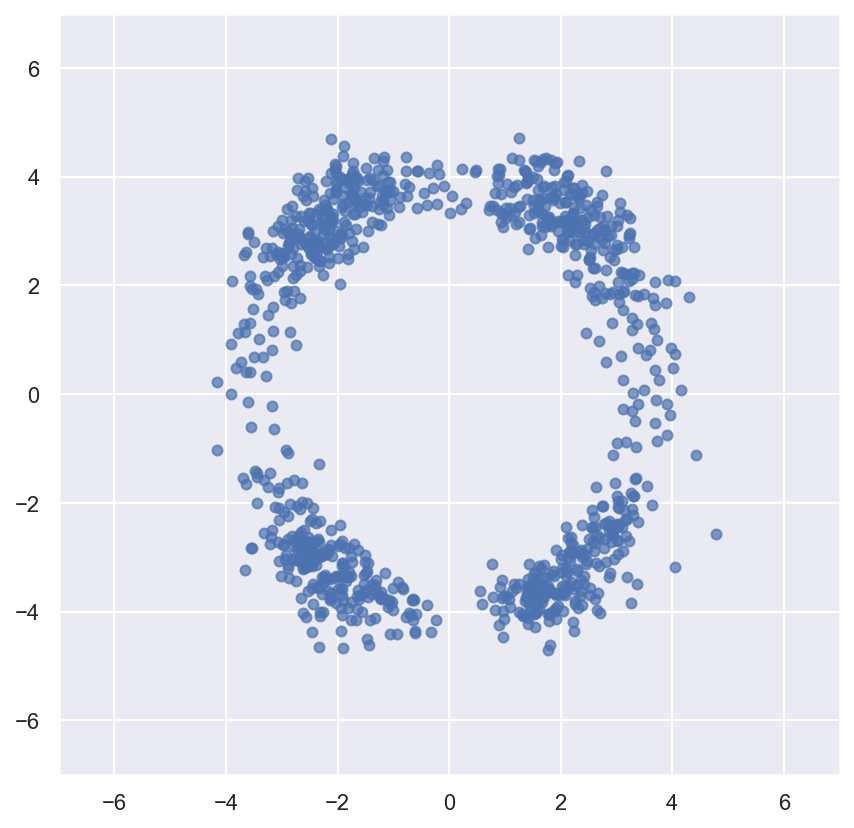

In [95]:
z0, zk, log_jacobians, mu, log_var = flow(1000)
scatter_points(zk.data.numpy())

In [67]:
def show_samples(s0, sk, mu, title):
    
    alpha = 0.2
    
    mask_1 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] > mu[1])
    mask_2 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] < mu[1])
    mask_3 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] > mu[1])
    mask_4 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] < mu[1])
    
    for s, title in zip([s0, sk], ['Base distribution $z_0$', title]):
        plt.figure(figsize=(8, 8))
        plt.title(title)
        plt.scatter(s[:, 0][mask_1], s[:, 1][mask_1], color='C0', alpha=alpha)
        plt.scatter(s[:, 0][mask_2], s[:, 1][mask_2], color='C1', alpha=alpha)
        plt.scatter(s[:, 0][mask_3], s[:, 1][mask_3], color='C3', alpha=alpha)
        plt.scatter(s[:, 0][mask_4], s[:, 1][mask_4], color='C4', alpha=alpha)

        plt.xlim(-7.5, 7.5)
        plt.ylim(-7.5, 7.5)
        plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

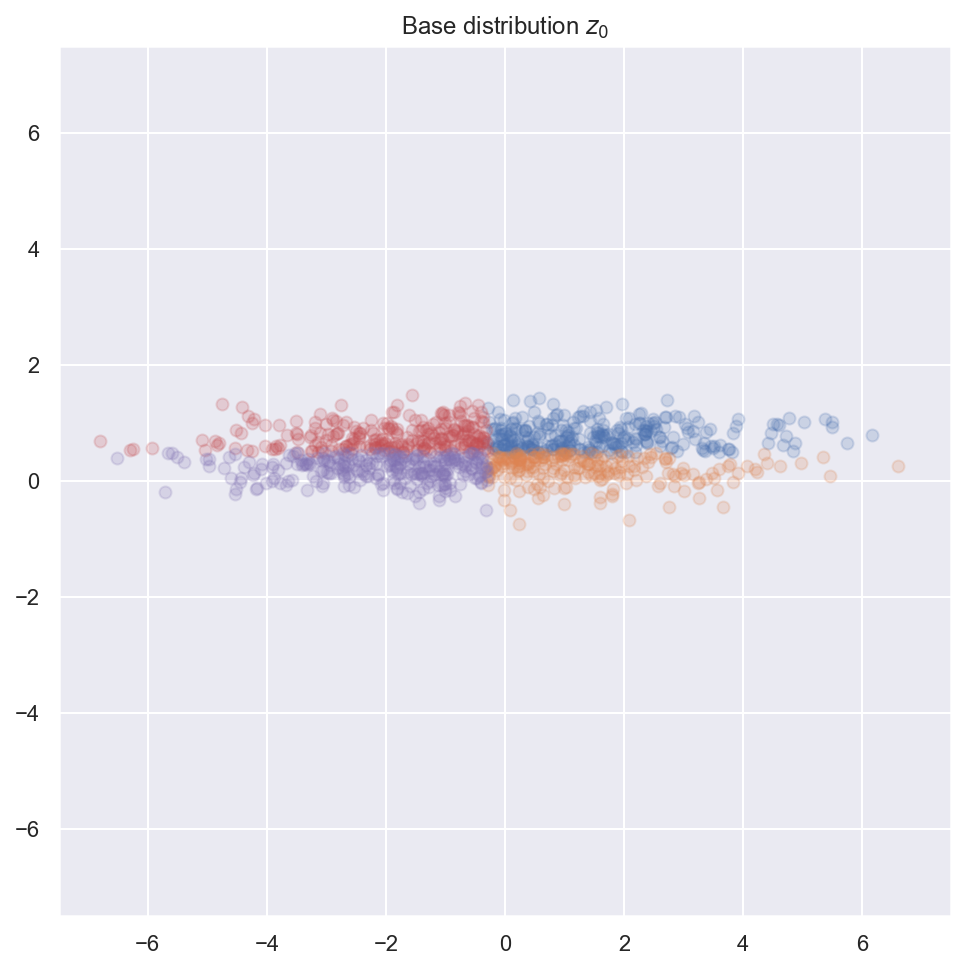

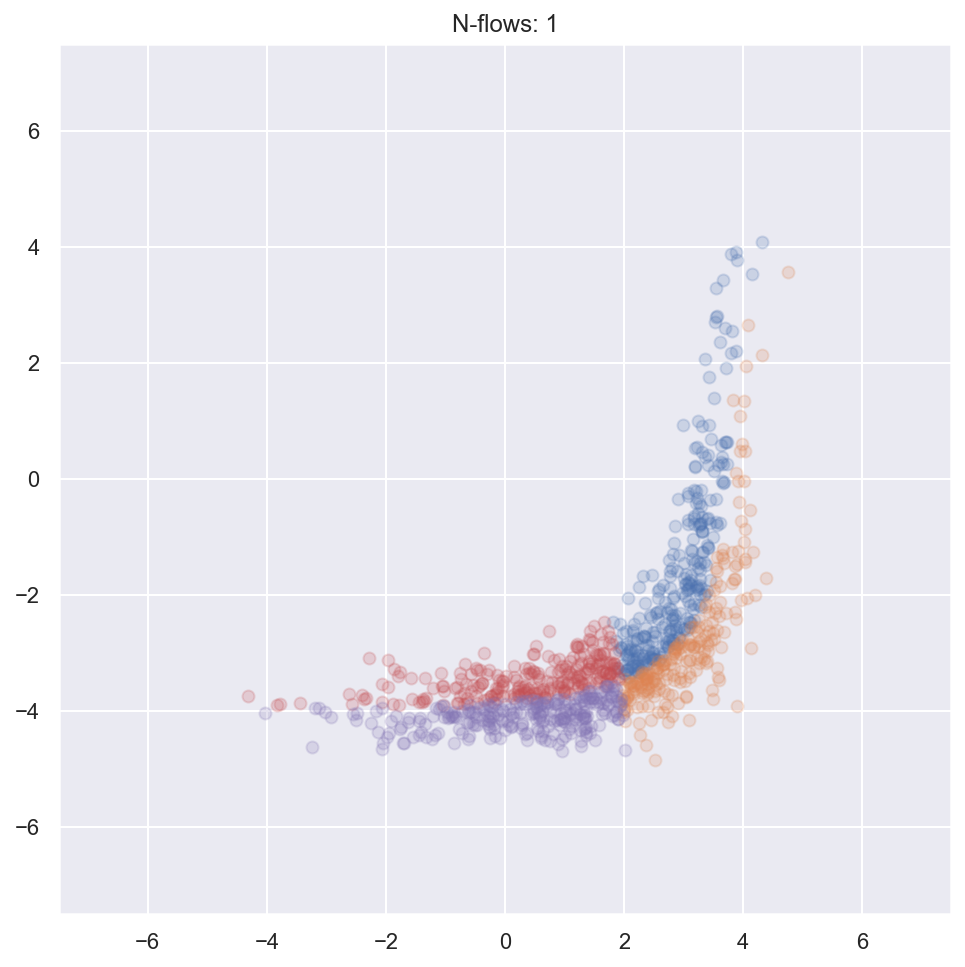

  0%|          | 0/10000 [00:00<?, ?it/s]

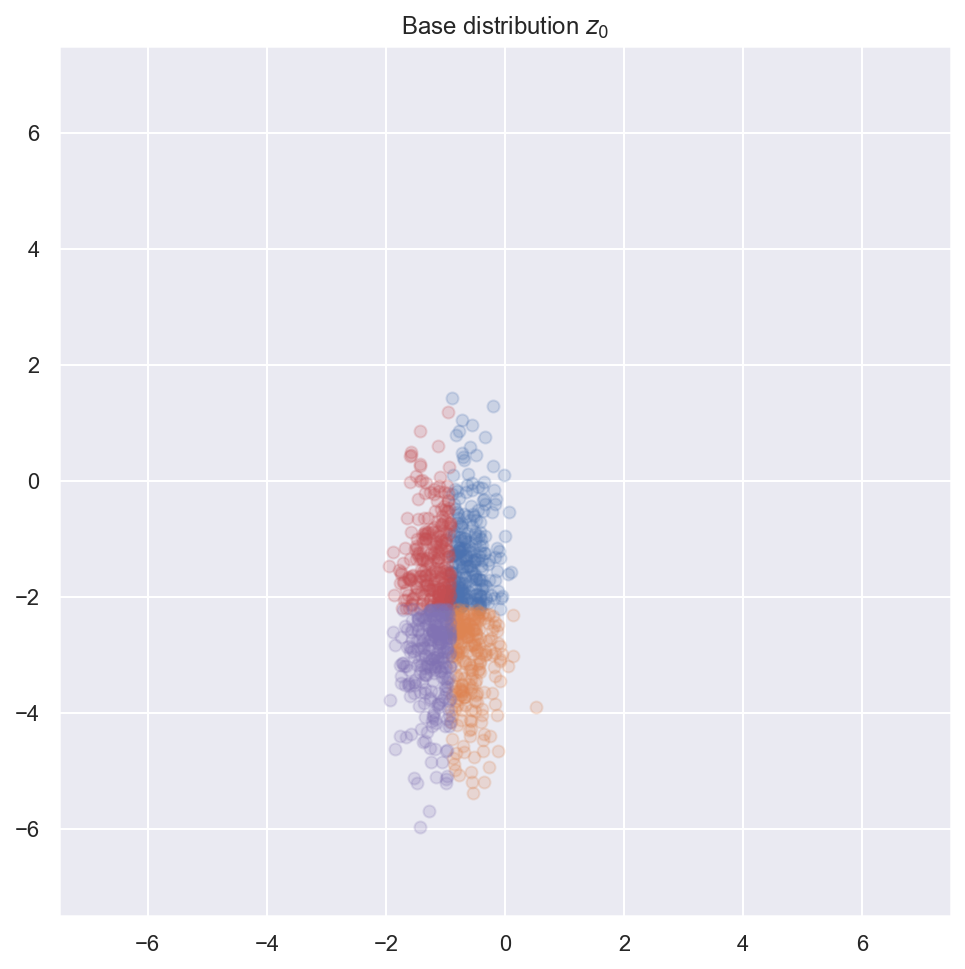

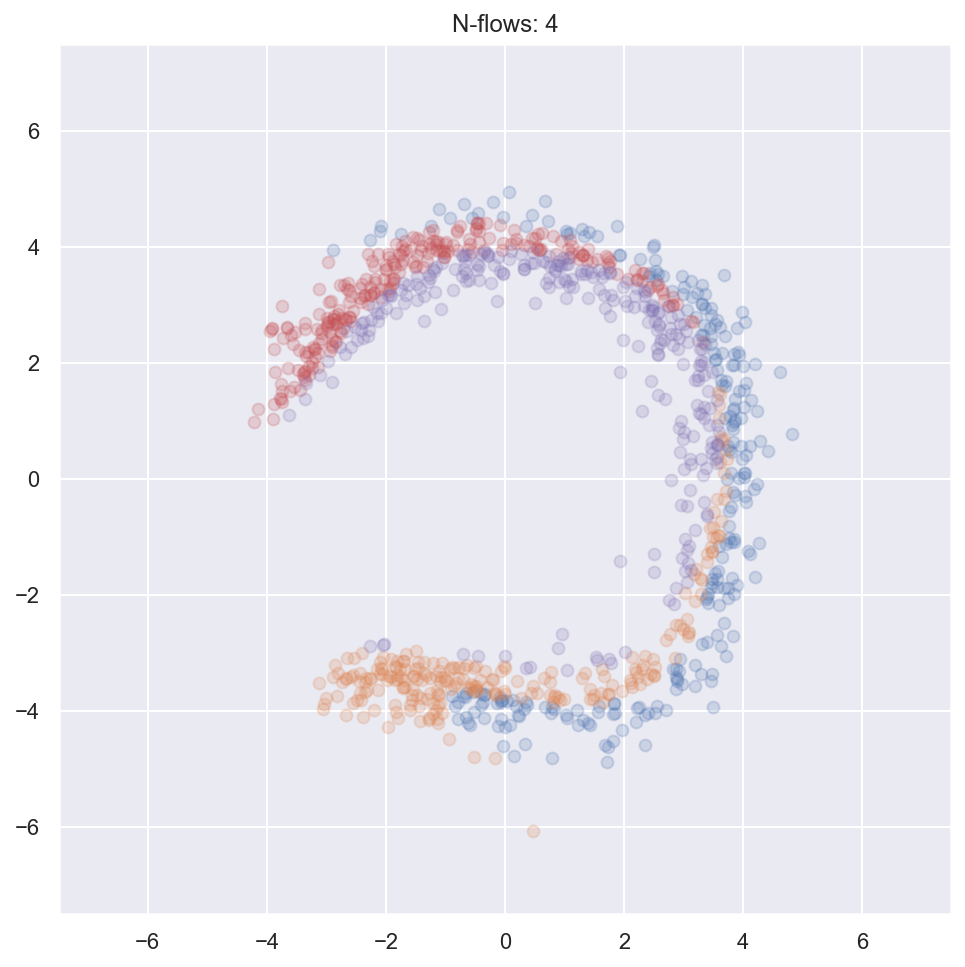

  0%|          | 0/10000 [00:00<?, ?it/s]

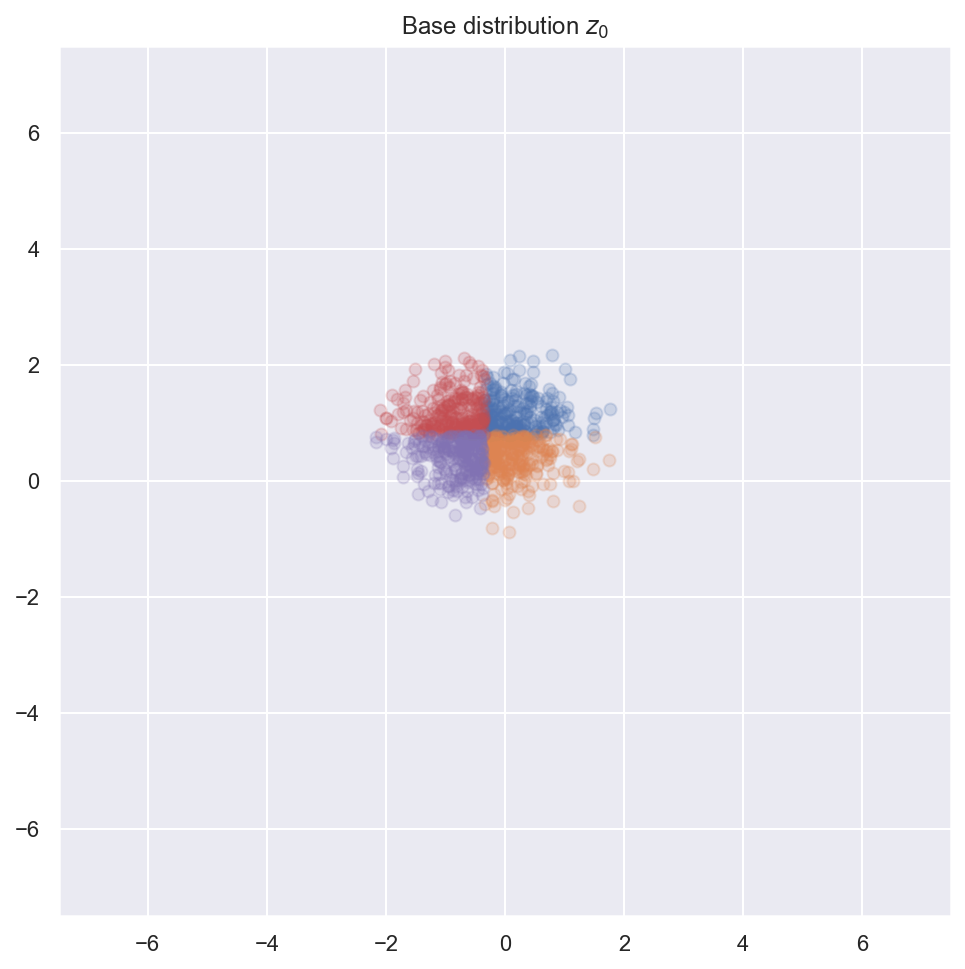

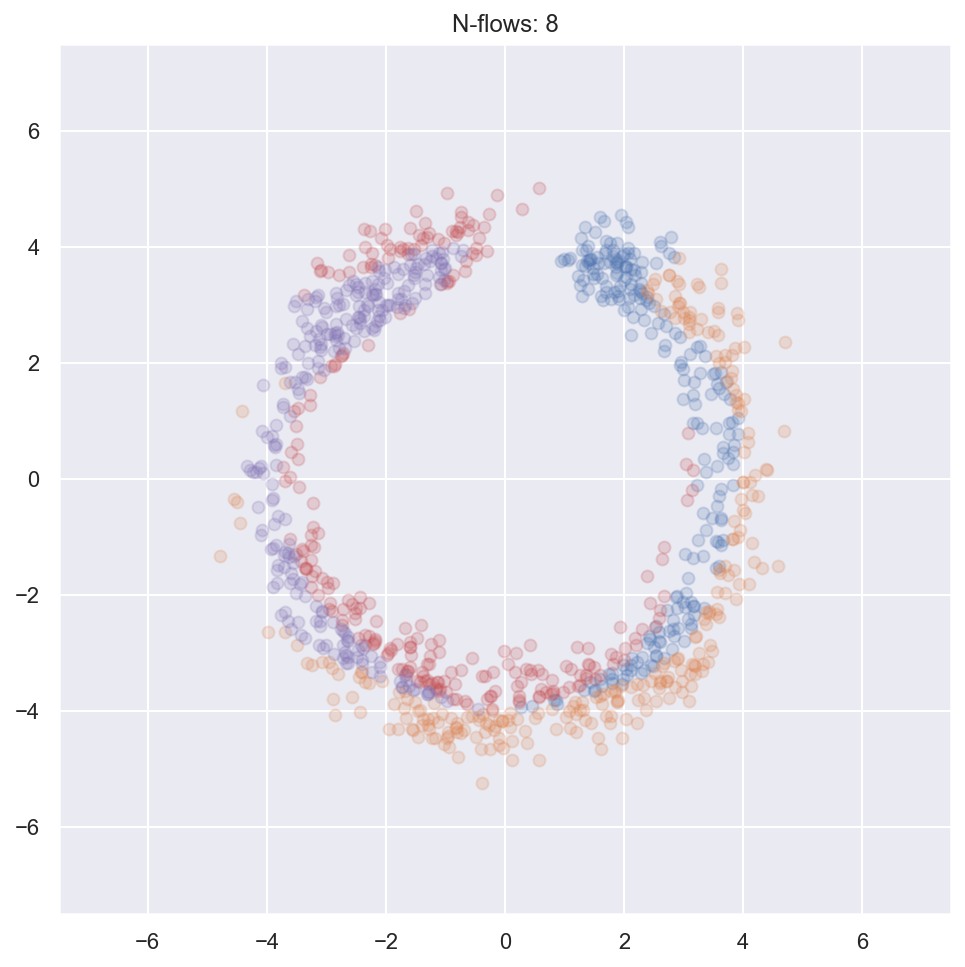

  0%|          | 0/10000 [00:00<?, ?it/s]

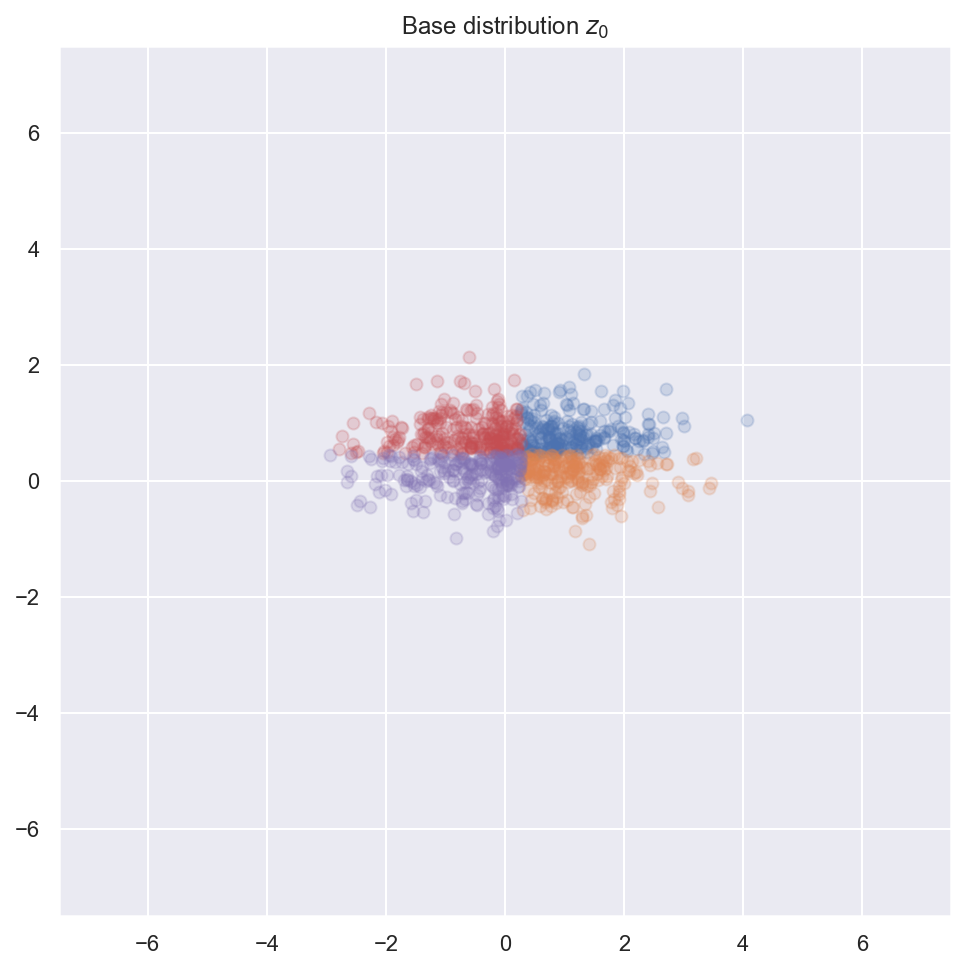

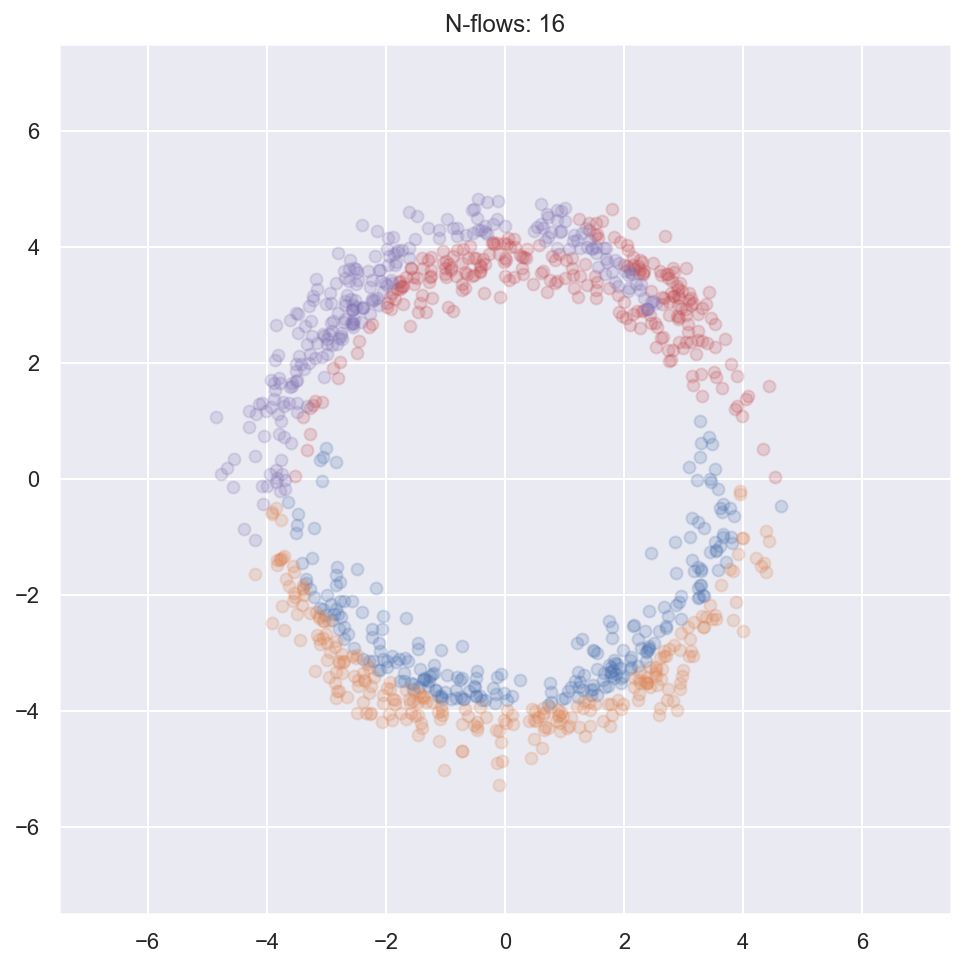

In [69]:
for n_flows in [1, 4, 8, 16]:
    flow, hist_loss = train_flow(n_flows=n_flows, epochs=10000, n_sample=1000)
    z0, zk, ldj, mu, log_var = flow(1000)
    show_samples(z0.data, zk.data, mu, f"N-flows: {n_flows}")

In [76]:
def plot_density():
    x1 = np.linspace(-7, 7, 300)
    x2 = np.linspace(-7, 7, 300)
    x1_s, x2_s = np.meshgrid(x1, x2)
    x_field = np.concatenate([x1_s[..., None], x2_s[..., None]], axis=-1)
    x_field = torch.tensor(x_field, dtype=torch.float)

    plt.figure(figsize=(8, 8))
    plt.title("Target distribution")
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.contourf(x1_s, x2_s, target_density(x_field), cmap='viridis')
    plt.show()

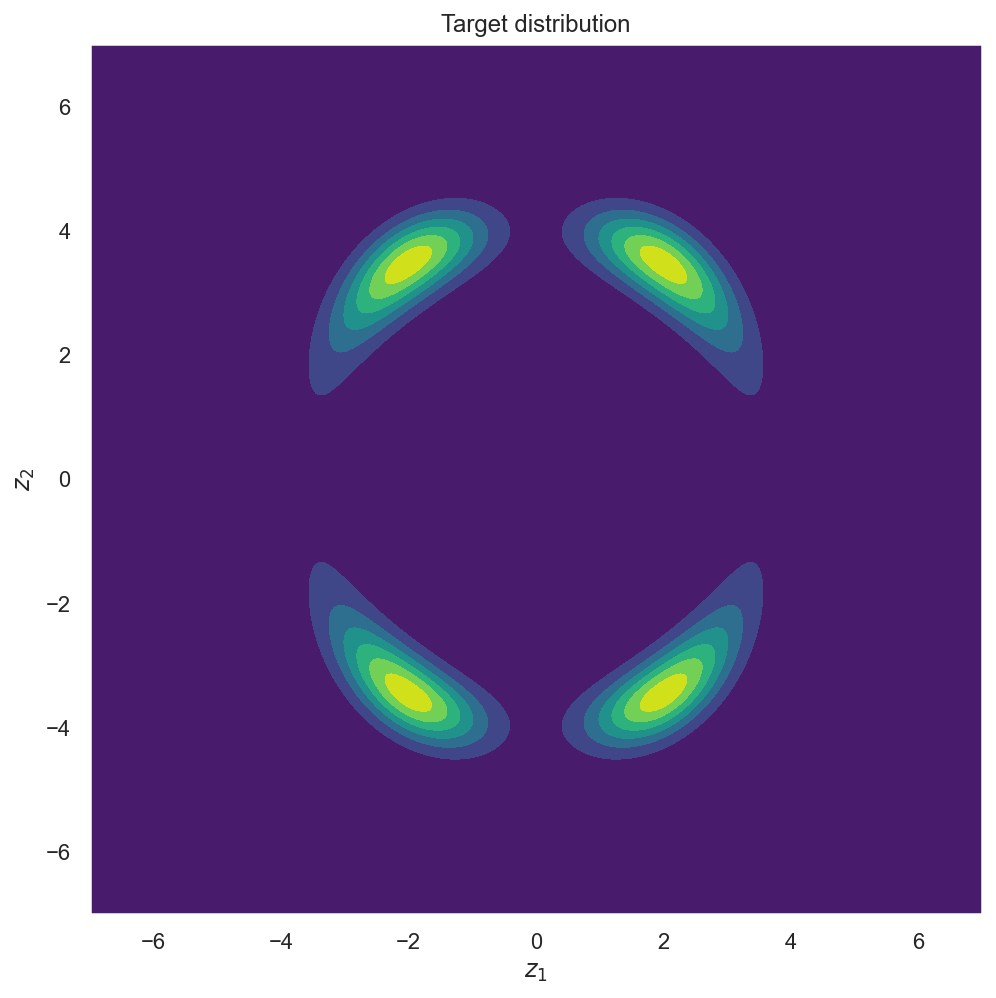

In [77]:
plot_density()